In [76]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from pmdarima import auto_arima
from pmdarima import arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
%config InlineBackend.figure_format = 'svg'

In [77]:
csv_path = './daily-total-female-births.csv'
df = pd.read_csv(csv_path)
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB
         Date  Births
0  1959-01-01      35
1  1959-01-02      32
2  1959-01-03      30
3  1959-01-04      31
4  1959-01-05      44


In [78]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.drop('Date', axis=1, inplace=True)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [80]:
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [81]:
def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()

def draw_trend(timeseries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()

    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

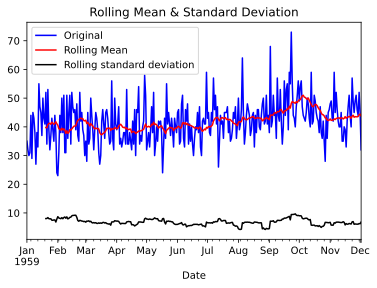

In [82]:
ts = df[ :pd.to_datetime('1959-12-02')]['Births']

draw_trend(ts, 20)

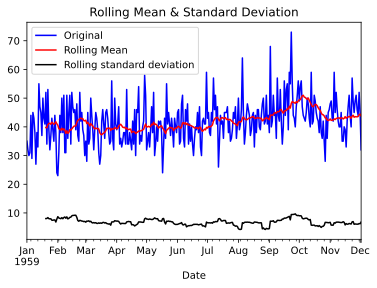

In [83]:
ts_log = np.log(ts)
ts_log= ts
draw_trend(ts_log, 20)

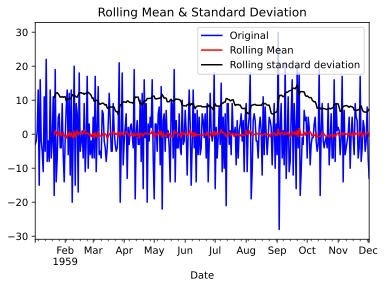

In [84]:
diff_1_1 = ts_log.diff(1)
# True表示修改数据
diff_1_1.dropna(inplace=True)
draw_trend(diff_1_1,20)

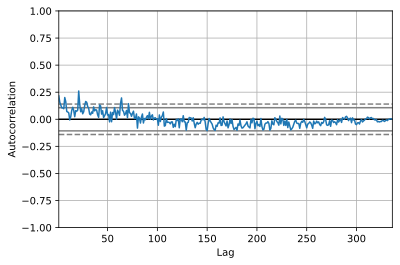

In [85]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts_log)
plt.show()

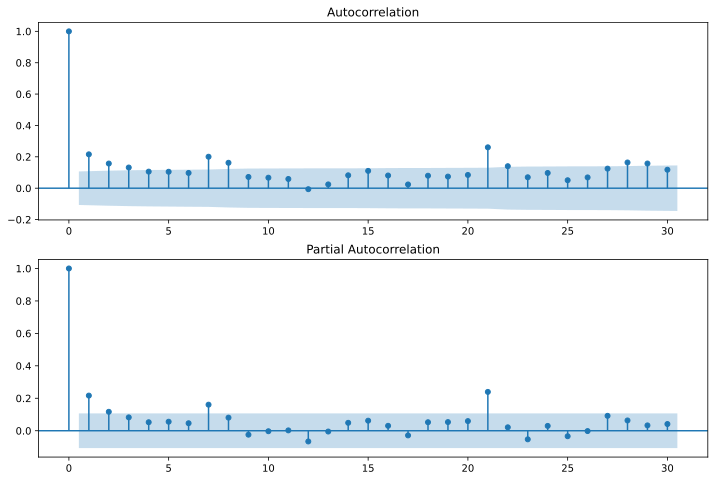

In [86]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log,lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log,lags=30,ax=ax2)
plt.show()

# p = 1/2, d = 0/1, q = 2

In [87]:
def auto_parameters(data, s_num):
    
    kpss_diff = arima.ndiffs(data, alpha=0.05, test='kpss', max_d=s_num)
    adf_diff = arima.ndiffs(data, alpha=0.05, test='adf', max_d=s_num)
    d = max(kpss_diff, adf_diff)
    D = arima.nsdiffs(data, s_num)

    stepwise_model = auto_arima(data, start_p=0, start_q=0,
                                max_p=6, max_q=4, max_d=2, m=s_num,
                                seasonal=True, d=d, D=D, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    print("AIC: ", stepwise_model.aic())
    print(stepwise_model.order)		# (p,d,q)
    print(stepwise_model.seasonal_order)	# (P,D,Q,S)
    print(stepwise_model.summary())		# 详细模型
    return stepwise_model.order, stepwise_model.seasonal_order

order, sea_order = auto_parameters(ts_log, 30)

# model=sm.tsa.statespace.SARIMAX(ts_log,order=(6, 1, 2),seasonal_order=(0,0,0,0))
model=sm.tsa.statespace.SARIMAX(ts_log,order=order,seasonal_order=sea_order)

results=model.fit()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[30] intercept   : AIC=2449.812, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2446.255, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2369.839, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=2272.312, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2444.255, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=2270.627, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=2272.301, Time=0.60 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=2274.204, Time=1.65 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=2268.351, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=2270.148, Time=1.04 sec
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=2270.158, Time=1.40 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=2367.841, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[30] inte

d:\11516\usual\anaconda\envs\pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
d:\11516\usual\anaconda\envs\pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


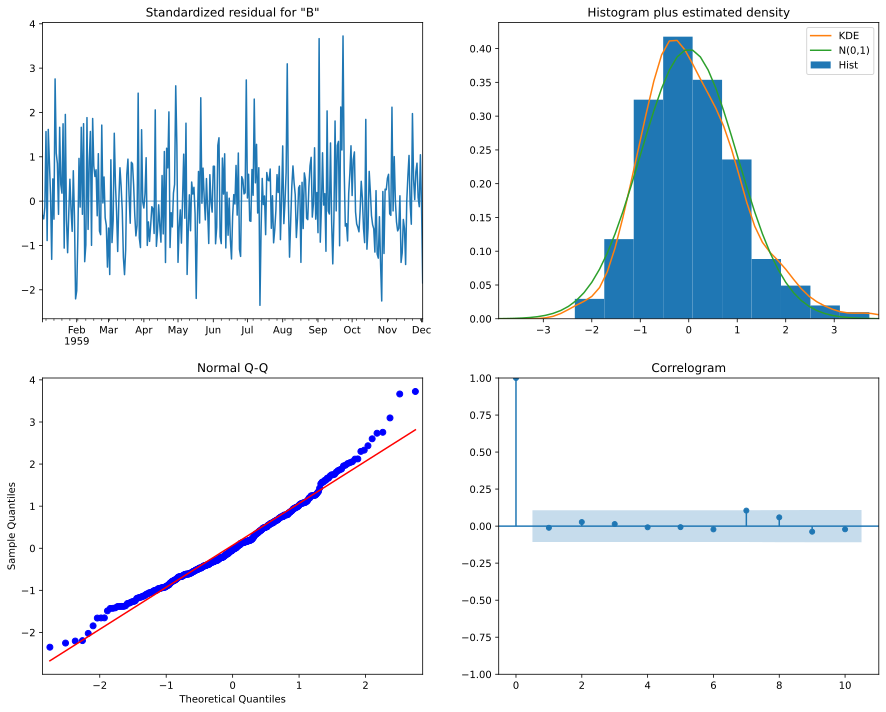

In [88]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [93]:
predict_ts = results.predict()
predict_ts_df = results.predict(start=pd.to_datetime('1959-11-20'), dynamic=True, full_results=True)
predict_ts_af = results.forecast(30)

In [94]:
# log_recover = np.exp(predict_ts)
log_recover = predict_ts
log_recover.dropna(inplace=True)

# log_recover_df = np.exp(predict_ts_df)
log_recover_df = predict_ts_df
log_recover_df.dropna(inplace=True)

# log_recover_af = np.exp(predict_ts_af)
log_recover_af = predict_ts_af
log_recover_af.dropna(inplace=True)

In [95]:
# testsize = 100
# log_recover = log_recover[-testsize:]
ts = df['Births']
# ts = ts[-testsize:]

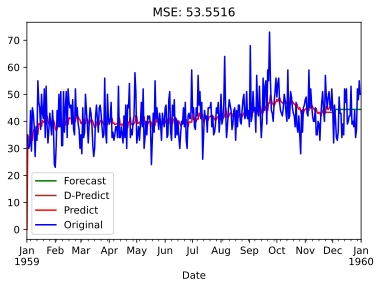

In [98]:
# log_recover.plot()
log_recover_af.plot(color='green', label='Forecast')
log_recover_df.plot(color='brown', label='D-Predict')
log_recover.plot(color='red', label = 'Predict')
ts.plot(color='blue', label='Original')
plt.legend(loc='best')
plt.title('MSE: %.4f'% mean_squared_error(log_recover,ts[log_recover.index]))
plt.show()